# 1 Introduction


If someone comes to borrow money, would you lend it or not? Why? And if there are 1000 people who come to borrow money, how do you decide who to lend to and who to reject? This is happening in banks, and the decision-making process uses a tool called credit scoring. By using customer data, credit scoring predicts whether a customer will default on their loan after borrowing.

In this notebook, we will explore how likely customers are to default on their loans (Bad rate) based on their different characteristics. Let's take a look!

如果有人来向你借钱，你会借还是不借?为什么?如果有1000个人来借钱，你如何决定借钱给谁，拒绝谁?这种情况正在银行中发生，决策过程使用一种称为信用评分的工具。通过使用客户数据，信用评分可以预测客户在借款后是否会拖欠贷款。

在本手册中，我们将根据客户的不同特点探讨他们拖欠贷款的可能性(坏帐率)。让我们一起来看看!

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

In [2]:
credit = pd.read_csv('credit_record.csv')
application = pd.read_csv('application_record.csv')

# 2 Explore Data

In [3]:
print('Credit Shape:', credit.shape)
credit.head()

Credit Shape: (1048575, 3)


,ID,MONTHS_BALANCE,STATUS
0,5001711,0,X
1,5001711,-1,0
2,5001711,-2,0
3,5001711,-3,0
4,5001712,0,C


In [4]:
print('Application Shape:', application.shape)
application.head()

Application Shape: (438557, 18)


,ID,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,NAME_INCOME_TYPE,NAME_EDUCATION_TYPE,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,DAYS_BIRTH,DAYS_EMPLOYED,FLAG_MOBIL,FLAG_WORK_PHONE,FLAG_PHONE,FLAG_EMAIL,OCCUPATION_TYPE,CNT_FAM_MEMBERS
0,5008804,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
1,5008805,M,Y,Y,0,427500.0,Working,Higher education,Civil marriage,Rented apartment,-12005,-4542,1,1,0,0,NaN,2.0
2,5008806,M,Y,Y,0,112500.0,Working,Secondary / secondary special,Married,House / apartment,-21474,-1134,1,0,0,0,Security staff,2.0
3,5008808,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0
4,5008809,F,N,Y,0,270000.0,Commercial associate,Secondary / secondary special,Single / not married,House / apartment,-19110,-3051,1,0,1,1,Sales staff,1.0


Normally, credit scoring data would have labels indicating whether a customer is good or bad. However, this dataset does not include such labels. Therefore, we need to find a way to identify which customers are which in order to investigate the trends of each variable.

通常，信用评分数据会有标签，表明客户是好是坏。然而，这个数据集不包括这样的标签。因此，我们需要找到一种方法来确定哪些客户是哪些，以便调查每个变量的趋势。

In [5]:
print(credit.info())
print('\n','*'*50, '\n')
print(application.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1048575 entries, 0 to 1048574
Data columns (total 3 columns):
 #   Column          Non-Null Count    Dtype 
---  ------          --------------    ----- 
 0   ID              1048575 non-null  int64 
 1   MONTHS_BALANCE  1048575 non-null  int64 
 2   STATUS          1048575 non-null  object
dtypes: int64(2), object(1)
memory usage: 24.0+ MB
None

 ************************************************** 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 438557 entries, 0 to 438556
Data columns (total 18 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   ID                   438557 non-null  int64  
 1   CODE_GENDER          438557 non-null  object 
 2   FLAG_OWN_CAR         438557 non-null  object 
 3   FLAG_OWN_REALTY      438557 non-null  object 
 4   CNT_CHILDREN         438557 non-null  int64  
 5   AMT_INCOME_TOTAL     438557 non-null  float64
 6   NAME_INCOME_TYPE     43

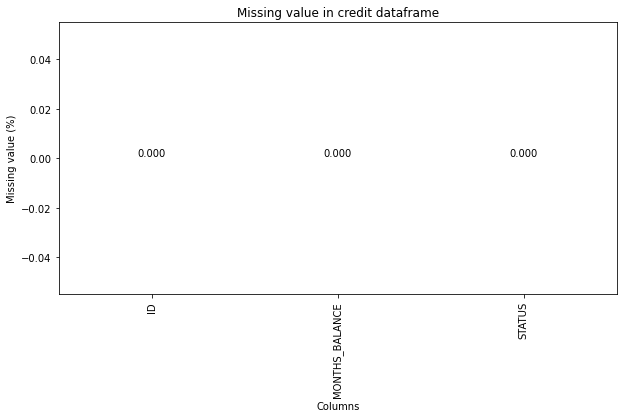

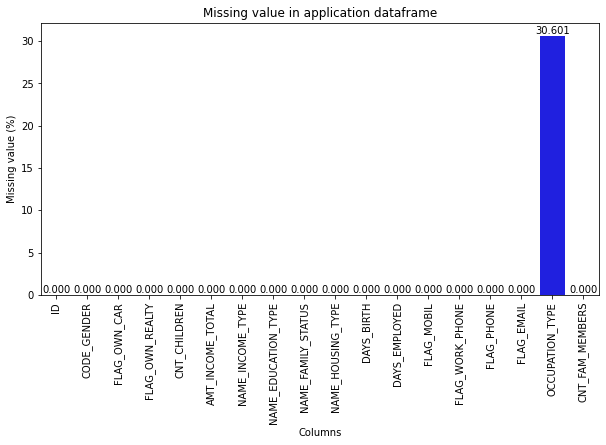

In [6]:
# 绘制柱形图
for df_name, df in zip(['credit', 'application'], [credit, application]):
    # 计算缺失率
    missing_value = []
    columns = []
    for col in df.columns:
        pct_missing = np.mean(df[col].isna()) * 100
        missing_value.append(pct_missing)
        columns.append(col)
            
    # 绘图
    plt.figure(figsize=(10, 5))
    sns.barplot(x=columns, y=missing_value, color='blue')
    plt.title(f"Missing value in {df_name} dataframe")
    plt.xticks(rotation=90)
    plt.xlabel("Columns")
    plt.ylabel("Missing value (%)")
    for i in range(len(columns)):
        plt.text(i, missing_value[i], f"{missing_value[i]:.3f}", ha='center', va='bottom')
    plt.show()

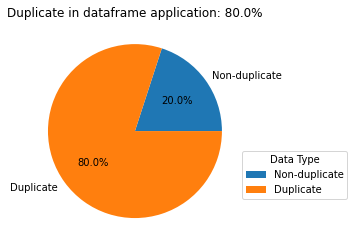

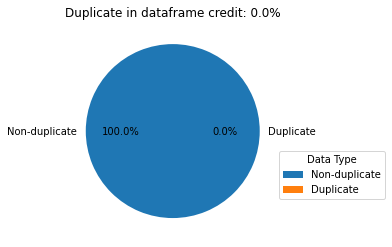

In [7]:
# 计算重复率
duplicate_application = round(application.loc[:, application.columns != 'ID'].duplicated().sum()/len(application), 1)
duplicate_credit = round(credit.duplicated().sum()/len(credit), 1)

# 绘制饼图
labels = ['Non-duplicate', 'Duplicate']
sizes = [100-duplicate_application*100, duplicate_application*100]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title(f"Duplicate in dataframe application: {duplicate_application*100}%")
plt.legend(title="Data Type", loc="center right", bbox_to_anchor=(1.5, 0.3))
plt.show()

labels = ['Non-duplicate', 'Duplicate']
sizes = [100-duplicate_credit*100, duplicate_credit*100]
plt.pie(sizes, labels=labels, autopct='%1.1f%%')
plt.title(f"Duplicate in dataframe credit: {duplicate_credit*100}%")
plt.legend(title="Data Type", loc="center right", bbox_to_anchor=(1.5, 0.3))
plt.show()

In [8]:
# 不同值的个数
print('Credit different values number:')
print(credit.nunique())
print('\n', '*'*30, '\n')
print('Application different values number:')
print(application.nunique())

Credit different values number:
ID                45985
MONTHS_BALANCE       61
STATUS                8
dtype: int64

 ****************************** 

Application different values number:
ID                     438510
CODE_GENDER                 2
FLAG_OWN_CAR                2
FLAG_OWN_REALTY             2
CNT_CHILDREN               12
AMT_INCOME_TOTAL          866
NAME_INCOME_TYPE            5
NAME_EDUCATION_TYPE         5
NAME_FAMILY_STATUS          5
NAME_HOUSING_TYPE           6
DAYS_BIRTH              16379
DAYS_EMPLOYED            9406
FLAG_MOBIL                  1
FLAG_WORK_PHONE             2
FLAG_PHONE                  2
FLAG_EMAIL                  2
OCCUPATION_TYPE            18
CNT_FAM_MEMBERS            13
dtype: int64


# 2 Data Cleaning

## 2.1 Delete feature

In [9]:
# FLAG_MOBILE 列只包含一个值，这对数据分析没有用处，移除。
application.drop('FLAG_MOBIL', axis=1, inplace=True)

You can noticed that the "flag mobil" column contains only one value, which is not useful for data analysis. Therefore, this column can be removed.

您可以注意到，“flag mobil”列只包含一个值，这对数据分析没有用处。因此，这一列可以被移除。

## 2.2 Drop duplicates

In [10]:
# 去除 DataFrame application 中除了第一列以外的重复行，并保留第一个出现的重复行。
application = application.drop_duplicates(subset=application.columns[1:], keep='first')

## 2.3 Fill missing values

In [11]:
# 填充缺失值绘图
# The "occupation type" column has a missing value of 33%. 
# I replaced it with the category "Other".
application['OCCUPATION_TYPE'].fillna(value='Other', inplace=True)
application['OCCUPATION_TYPE'].head()

0              Other
2     Security staff
3        Sales staff
7              Other
10       Accountants
Name: OCCUPATION_TYPE, dtype: object

## 2.4 Age feature

这段代码的含义是：从 DataFrame application 中计算出每个申请人的年龄，并将其存储在一个名为 'age' 的新列中，然后删除原始数据中的 'days_birth' 列。

具体来说，代码分为三步：

计算每个申请人的年龄
该步骤使用了 Pandas 库中的 to_timedelta() 和 dt.days 函数计算出 'days_birth' 列中的天数，并除以 -365.25 得到对应的年龄。使用了 Numpy 中的 ceil() 函数向上取整，确保计算结果为整数。

将年龄存储在新列中
该步骤使用了 DataFrame 中的索引功能和赋值语句，将计算得到的年龄存储在名为 'age' 的新列中。

删除原始数据中的 'days_birth' 列
该步骤使用了 drop() 函数删除 DataFrame 中的 'days_birth' 列。其中，axis=1 表示按列删除，inplace=True 表示直接修改原始 DataFrame，而不返回副本。

最后，.head() 函数用于查看新生成的 'age' 列的前几行数据。

In [12]:
# Count backwards from current day (0), -1 means yesterday
application['AGE'] = np.ceil(pd.to_timedelta(application['DAYS_BIRTH'], unit='D').dt.days / -365.25)
application.drop('DAYS_BIRTH', axis=1, inplace=True)

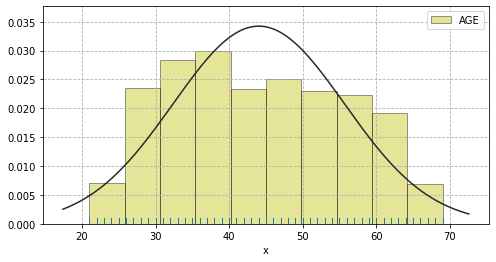

In [13]:
# 直方图
from scipy.stats import norm #使用直方图和最大似然高斯分布拟合绘制分布

rs = np.random.RandomState(50)  # 设置随机数种子
s = application['AGE']

plt.figure(figsize=(8,4))
sns.distplot(s, bins=10, hist=True, kde=False, norm_hist=False,
            rug=True, vertical=False,label='AGE',
            axlabel='x',hist_kws={'color':'y','edgecolor':'k'},
            fit=norm)
# 用标准正态分布拟合
plt.legend()
plt.grid(linestyle='--')
plt.show()

## 2.5 Binary Columns

In [14]:
application["CODE_GENDER"].replace(['F','M'], [1,0], inplace=True)
application["FLAG_OWN_CAR"].replace(['Y','N'], [1,0], inplace=True)
application["FLAG_OWN_REALTY"].replace(['Y','N'], [1,0], inplace=True)

## 2.6 Unemployed Feature

In [15]:
# Count backwards from current day(0). If positive, it means the person currently unemployed.
# TODO 以后可做，失业多少天
application['UNEMPLOYED'] = 0
application.loc[-application['DAYS_EMPLOYED']<0, 'UNEMPLOYED']=1

print('unemployment column:')
print(application['UNEMPLOYED'].value_counts(normalize=True))

unemployment column:
0    0.825864
1    0.174136
Name: UNEMPLOYED, dtype: float64


这段代码的含义是：在 DataFrame application 中新增一个名为 'unemployed' 的列，并根据 'days_employed' 列中的值判断每个申请人是否失业。具体来说，该步骤分为三个部分：

新增一个名为 'unemployed' 的列
该步骤使用了 DataFrame 中的索引功能和赋值语句，在 DataFrame application 中新增一个名为 'unemployed' 的列，并将所有行的值都设为 0。

根据 'days_employed' 列中的值判断每个申请人是否失业
该步骤使用了 Pandas 库中的 loc 函数和布尔索引技术，根据 'days_employed' 列中的值判断每个申请人是否失业。具体来说，对于 'days_employed' 列中小于 0 的值，将对应行的 'unemployed' 列的值设为 1，表示该申请人失业。大于等于 0 的值则表示该申请人有工作，因此 'unemployed' 列的值保持为 0。

输出 'unemployed' 列的取值数量比例
该步骤使用了 'value_counts()' 和 'normalize=True' 参数，计算 'unemployed' 列中不同取值的数量比例。其中，'value_counts()' 函数用于计算每种取值的数量，'normalize=True' 参数用于将数量转换为比例。

最后，输出 'unemployed' 列的取值数量比例。如果大多数申请人都有工作，则表示该数据集中大多数人都是有工作的，反之则表示失业率较高。

## 2.7 Years Employed Feature

In [16]:
application['YEARS_EMPLOYED'] = round((-application['DAYS_EMPLOYED']/365.25), 1)
application.loc[application['YEARS_EMPLOYED']<0, 'YEARS_EMPLOYED']=0

print('years_employed column:')
print(application['YEARS_EMPLOYED'].head())

years_employed column:
0     12.4
2      3.1
3      8.4
7      0.0
10     2.1
Name: YEARS_EMPLOYED, dtype: float64


In [17]:
application.drop('DAYS_EMPLOYED', axis=1, inplace=True)

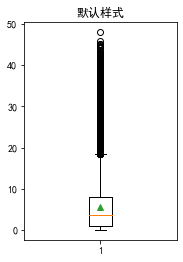

In [18]:
plt.rcParams['font.family'] = 'simhei'
plt.rcParams['axes.unicode_minus'] = False

plt.subplot(121)
plt.title("默认样式")
plt.boxplot(application['YEARS_EMPLOYED'], showmeans=True)

plt.show()

## 2.8 Number of children

In [19]:
application['CNT_FAM_MEMBERS'] = application['CNT_FAM_MEMBERS'].astype(int)
application['CNT_FAM_MEMBERS'].head()

0     2
2     2
3     1
7     1
10    2
Name: CNT_FAM_MEMBERS, dtype: int32

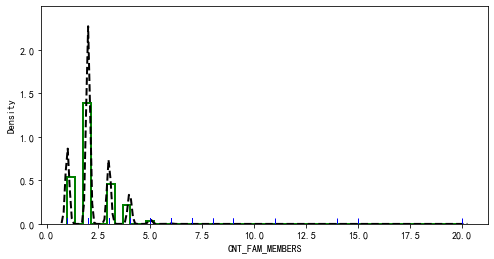

In [20]:
plt.figure(figsize=(8,4))
sns.distplot(application['CNT_FAM_MEMBERS'],rug = True,
            rug_kws = {'color':'b'} ,
            # 设置数据频率分布颜色
            kde_kws={"color": "k", "lw": 2, "label": "KDE",'linestyle':'--'},
            # 设置密度曲线颜色，线宽，标注、线形
            hist_kws={"histtype": "step", "linewidth": 2,"alpha": 1, "color": "g"})  
            # 设置箱子的风格、线宽、透明度、颜色
            # 风格包括：'bar', 'barstacked', 'step', 'stepfilled'
plt.show()

## 2.9 Label Good or Bad Customers

In [21]:
# credit['TARGET'] = credit['STATUS']
# credit['TARGET'].replace('X', 0, inplace=True)
# credit['TARGET'].replace('C', 0, inplace=True)
# credit['TARGET'] = credit['TARGET'].astype(int)
# credit.loc[credit['TARGET']>=1,'TARGET']=1

# target_df = pd.DataFrame(credit.groupby('ID')['TARGET'].agg(max)).reset_index()

In [22]:
# X 状态为 6，C 状态为 7
credit['TARGET'] = credit['STATUS']
credit['TARGET'].replace('X', 6, inplace=True)
credit['TARGET'].replace('C', 7, inplace=True)
credit['TARGET'] = credit['TARGET'].astype(int)

target_df = pd.DataFrame(credit.groupby('ID')['TARGET'].agg(max)).reset_index()

<AxesSubplot: title={'center': 'Density Plot'}, ylabel='Frequency'>

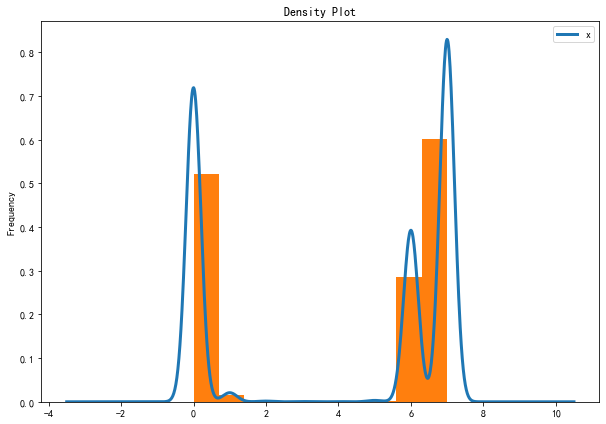

In [23]:
np.random.seed(123)

df = pd.DataFrame({"x": credit['TARGET']})

fig, ax = plt.subplots(figsize=(10, 7))
df.plot(kind="density", ax=ax, linewidth=3, title="Density Plot")
df.plot(kind="hist", ax=ax, density=True, legend=False)

Generally, bad customers account for approximately 16% of the total. Therefore, I selected customers who have been overdue for at least 1 months and labeled them as 1, while customers who are considered good are labeled as 0.

为了数据更精确没有转换为01，但若使用算法预测需要转换为01

In [24]:
# 0: 1-29 days past due 
# 1: 30-59 days past due 
# 2: 60-89 days overdue 
# 3: 90-119 days overdue 
# 4: 120-149 days overdue 
# 5: Overdue or bad debts, write-offs for more than 150 days 
# C: paid off that month 
# X: No loan for the month
target_df['TARGET'].value_counts(normalize=True)

7    0.493791
6    0.373600
0    0.112232
1    0.017854
5    0.001174
2    0.001066
3    0.000217
4    0.000065
Name: TARGET, dtype: float64

## 2.10 Merge credit and application data

In [25]:
df = pd.merge(application, target_df, how='inner', on='ID')

## 2.11 Rename Columns

In [26]:
df = df.rename(columns={'ID': 'id','CODE_GENDER': 'gender', 'FLAG_OWN_CAR': 'own_car',
                        'FLAG_OWN_REALTY':'own_property','CNT_CHILDREN':'num_children',
                        'AMT_INCOME_TOTAL':'total_income','NAME_INCOME_TYPE':'income_type',
                        'NAME_EDUCATION_TYPE':'education_type','NAME_FAMILY_STATUS':'family_status',
                        'NAME_HOUSING_TYPE':'housing_type','FLAG_WORK_PHONE':'work_phone',
                        'FLAG_PHONE':'phone','FLAG_EMAIL':'email','OCCUPATION_TYPE':'occupation_type',
                        'CNT_FAM_MEMBERS':'num_family','TARGET':'target', 'AGE':'age','UNEMPLOYED':'unemployed',
                        'YEARS_EMPLOYED':'years_employed'})

df = df[['id', 'gender', 'own_car', 'own_property', 'work_phone',
        'phone', 'email', 'unemployed', 'num_children', 'num_family',
        'total_income', 'age', 'years_employed',
        'income_type', 'education_type', 'family_status',
        'housing_type', 'occupation_type','target']]

# 3 The New Data

- ID (Client ID)
- Gender (Gender (1=Male, 0=Female))
- Own_car (Does client own a car? (1=Yes, 0=No))
- Own_property (Does client own property? (1=Yes, 0=No))
- Work_phone (Does client own a work phone? (1=Yes, 0=No))
- Phone (Does client own a phone? (1=Yes, 0=No))
- Email (Does client have an email address? (1=Yes, 0=No))
- Unemployed (Is client unemployed? (1=Yes, 0=No))
- Num_children (Number of children)
- Num_family (Number of family members)
- Total_income (Total income (chinese yuan))
- Age
- Years_employed
- Income_type
- Education_type
- Family_status
- Housing_type
- Occupation_type
- Target (1=Bad, 0=Good)

- ID(客户端ID)
- 性别(性别(1=男，0=女))
- 客户端是否拥有一辆车?(1 =是的,0 = No))
- Own_property(客户端拥有财产吗?(1 =是的,0 = No))
- 客户端是否有工作电话?(1 =是的,0 = No))
- 电话(客户是否有电话?(1 =是的,0 = No))
- 电子邮件(客户有电子邮件地址吗?(1 =是的,0 = No))
- 失业(客户是否失业?(1 =是的,0 = No))
- Num_children(子节点数)
- Num_family(家庭成员数)
- 总收入(总收入(元))
- 年龄
- Years_employed
- Income_type
- Education_type
- Family_status
- Housing_type
- Occupation_type
- 目标(1=坏，0=好)

# 4 Prediction

In [27]:
from sklearn import preprocessing
lbl = preprocessing.LabelEncoder()
df['num_children'] = lbl.fit_transform(df['num_children'].astype(int))
df['num_family'] = lbl.fit_transform(df['num_family'].astype(int))
df['total_income'] = lbl.fit_transform(df['total_income'].astype(float))
df['age'] = lbl.fit_transform(df['age'].astype(float))
df['years_employed'] = lbl.fit_transform(df['years_employed'].astype(float))
df['income_type'] = lbl.fit_transform(df['income_type'].astype(str)).astype('int64')#将提示的包含错误数据类型这一列进行转换
df['education_type'] = lbl.fit_transform(df['education_type'].astype(str)).astype('int64')
df['family_status'] = lbl.fit_transform(df['family_status'].astype(str)).astype('int64')
df['housing_type'] = lbl.fit_transform(df['housing_type'].astype(str)).astype('int64')
df['occupation_type'] = lbl.fit_transform(df['occupation_type'].astype(str)).astype('int64')

# 4.1 Data Preperation & Spliting

In [28]:
from sklearn.model_selection import train_test_split

In [29]:
# 加载样本数据集
X=df.drop(['id', 'target'], axis=1)
y=df['target']

# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=2023) # 数据集分割

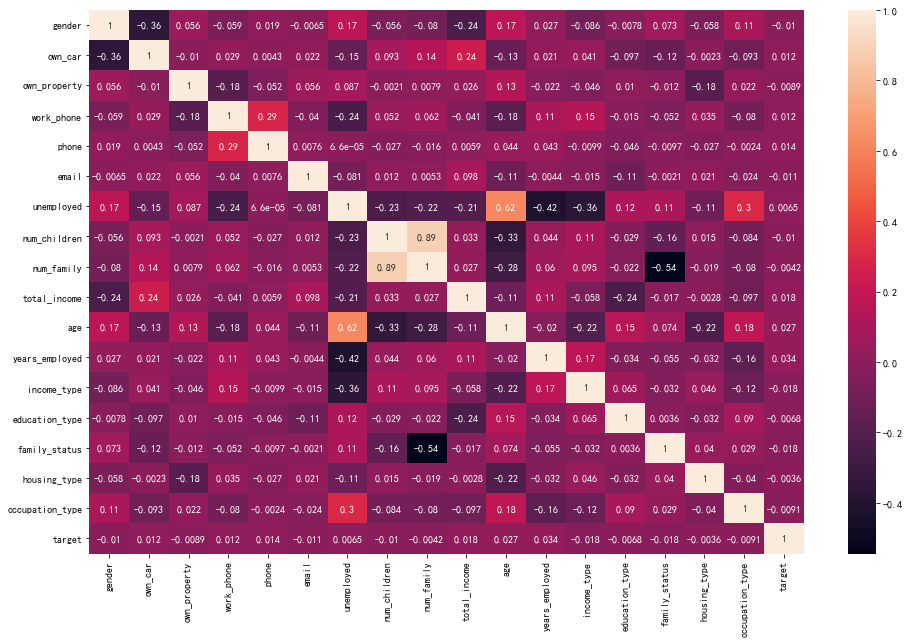

In [30]:
plt.figure(figsize = (16,10))
sns.heatmap(df.drop(['id'], axis=1).corr(),annot=True)
plt.show()

## 4.1 XGBoost

In [31]:
import xgboost as xgb
from xgboost import plot_importance
from sklearn.metrics import accuracy_score   # 准确率

[11:23:32] WARNING: ..\src\learner.cc:576: 
Parameters: { "num_boost_round" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:23:32] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softmax' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
accuarcy: 43.98%


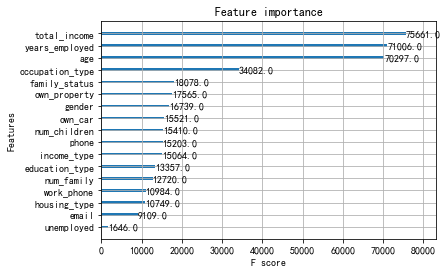

In [32]:
# 算法参数
params = {
    'objective': 'multi:softmax',
    'num_class': 8,
    'num_boost_round': 100,
    'booster': 'gbtree',
    'max_depth': 10,
    'alpha': 0,  
    'lambda': 1,
    'subsample': 1,
    'colsample_bytree': 1,
    'colsample_bylevel': 1,
    'min_child_weight': 0,
    'eta': 0.1,
}

plst = list(params.items())

dtrain = xgb.DMatrix(X_train, y_train) # 生成数据集格式
num_rounds = 500
model = xgb.train(plst, dtrain, num_rounds) # xgboost模型训练

# 对测试集进行预测
dtest = xgb.DMatrix(X_test)
y_pred = model.predict(dtest)

# 计算准确率
accuracy = accuracy_score(y_test, y_pred)
print("accuarcy: %.2f%%" % (accuracy*100.0))

# 显示重要特征
plot_importance(model)
plt.show()

# 4.2 GBDT

In [33]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error
from sklearn.inspection import permutation_importance

In [34]:
# 获取特征值和目标值

# 获取特征名称
feature_name = df.columns

params = {'n_estimators': 500, # 弱分类器的个数
          'max_depth': 3,       # 弱分类器（CART回归树）的最大深度
          'min_samples_split': 5, # 分裂内部节点所需的最小样本数
          'learning_rate': 0.05,  # 学习率
          'loss': 'ls'}           # 损失函数：均方误差损失函数

In [35]:
GBDTreg = GradientBoostingRegressor(**params)
GBDTreg.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.05, min_samples_split=5,
                          n_estimators=500)

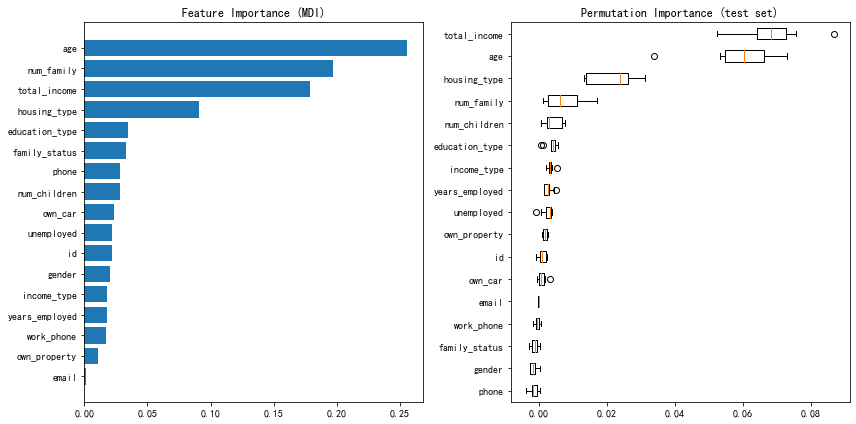

In [36]:
feature_importance = GBDTreg.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
fig = plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, np.array(feature_name)[sorted_idx])
plt.title('Feature Importance (MDI)')

result = permutation_importance(GBDTreg, X_test, y_test, n_repeats=10,
                                random_state=2023, n_jobs=2)
sorted_idx = result.importances_mean.argsort()
plt.subplot(1, 2, 2)
plt.boxplot(result.importances[sorted_idx].T,
            vert=False, labels=np.array(feature_name)[sorted_idx])
plt.title("Permutation Importance (test set)")
fig.tight_layout()
plt.show()

# 5 Comparation

In [37]:
from sklearn.preprocessing import label_binarize
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from xgboost.sklearn import XGBClassifier

In [38]:
features = [x for x in df.columns]

y_train.replace(2, 1, inplace=True)
y_train.replace(3, 1, inplace=True)
y_train.replace(4, 1, inplace=True)
y_train.replace(5, 1, inplace=True)
y_train.replace(6, 0, inplace=True)
y_train.replace(7, 0, inplace=True)

y_test.replace(2, 1, inplace=True)
y_test.replace(3, 1, inplace=True)
y_test.replace(4, 1, inplace=True)
y_test.replace(5, 1, inplace=True)
y_test.replace(6, 0, inplace=True)
y_test.replace(7, 0, inplace=True)

In [39]:
forest=RandomForestClassifier(n_estimators=100,random_state=2023) #　随机森林
forest.fit(X_train,y_train)
forest_y_score=forest.predict_proba(X_test)
# print(forest_y_score[:,1])
forest_score=forest.score(X_test,y_test) #准确率
print('forest_score:',forest_score)

Gbdt=GradientBoostingClassifier(random_state=2023) #CBDT
Gbdt.fit(X_train,y_train)
Gbdt_score=Gbdt.score(X_train,y_train) #准确率
print('Gbdt_score:',Gbdt_score)

Xgbc=XGBClassifier(random_state=2023)  #Xgbc
Xgbc.fit(X_train,y_train)
y_xgbc_pred=Xgbc.predict(X_test)
Xgbc_score=accuracy_score(y_test,y_xgbc_pred) #准确率
print('Xgbc_score:',Xgbc_score)

forest_score: 0.9773429454170958
Gbdt_score: 0.9783696291936433
[11:23:57] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Xgbc_score: 0.9759697905938894


In [40]:
y_test_hot = label_binarize(y_test, classes =(0, 1)) # 将测试集标签数据用二值化编码的方式转换为矩阵
Gbdt_y_score = Gbdt.decision_function(X_test) # 得到Gbdt预测的损失值
forest_fpr,forest_tpr,forest_threasholds=metrics.roc_curve(y_test.ravel(),forest_y_score[:,1].ravel()) # 计算ROC的值,forest_threasholds为阈值
Gbdt_fpr,Gbdt_tpr,Gbdt_threasholds=metrics.roc_curve(y_test_hot.ravel(),Gbdt_y_score.ravel()) # 计算ROC的值,Gbdt_threasholds为阈值

forest_auc=metrics.auc(forest_fpr,forest_tpr) #Gbdt_auc值
print('forest_auc',forest_auc)

Gbdt_auc=metrics.auc(Gbdt_fpr,Gbdt_tpr) #Gbdt_auc值
print('Gbdt_auc:',Gbdt_auc)

Xgbc_auc=roc_auc_score(y_test,y_xgbc_pred) #Xgbc_auc值
print('Xgbc_auc:',Xgbc_auc)

forest_auc 0.5275523984442525
Gbdt_auc: 0.5131401253241141
Xgbc_auc: 0.49912219101123595
